In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os 

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.lstm.make_dataset import StockReturnsDataset, \
    StockPricesDataset, get_prices_features, normalize_features,\
    generate_sentiment_features

from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df

# LSTM Analysis with Tech stock prices

## Prices

In [3]:
all_prices = pd.DataFrame([])

In [4]:
prices_df = yf.download(
    tickers= "AAPL",
    start="2020-01-10",
    end="2022-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [54]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    # "TSLA",
    "META",
    # "NFLX",
    "GOOGL",
    # "ORCL",
    # "ADBE",
    # "NVDA"
]
all_prices = []

for ticker in universe:
    prices_df = yf.download(
        tickers= ticker,
        start="2019-12-30",
        end="2023-08-23",
    )

    all_prices.append(get_prices_features(
        prices_df,
        ticker,
        lookback=10,
        pct_change= False
    ))


all_prices_df = pd.concat(all_prices)

all_prices_df["ticker"] = all_prices_df["ticker"]\
    .replace("META", "FB")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [55]:
prices_without_ticker = all_prices_df\
    .loc[:,all_prices_df.columns != 'ticker']

In [56]:
scaler, normalized_prices_df = normalize_features(
    prices_without_ticker
)

In [57]:
normalized_prices_df["ticker"] = all_prices_df["ticker"]

### Obtaining sentiment

In [89]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    # "TSLA",
    "FB",
    # "NFLX",
    "GOOGL",
    # "ORCL",
    # "ADBE",
    # "NVDA"
]

sentiment_list = []

for ticker in tqdm(universe):
    sentiment = generate_sentiment_features(ticker,
                                            updated= True)
    sentiment["ticker"] = ticker
    sentiment_list.append(sentiment)

sentiment_df = pd.concat(sentiment_list)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 16.12it/s]


In [206]:
news_df = read_company_news_df(
            "GOOGL" + "_updated"
        )

In [223]:
news_df.iloc[16].title

'Google Shuts Down Stadia In-House Game Development'

In [90]:
sentiment_df.reset_index(inplace=True)
normalized_prices_df.reset_index(inplace=True)

In [91]:
features_df = pd.merge(
    normalized_prices_df,
    sentiment_df,
    left_on=["ticker", "Date"],
    right_on=["ticker", "date"],
    how = "left"
)\
    .set_index(["Date", "ticker"])

In [92]:
selected_columns = ~((features_df.columns == "index") | (features_df.columns == "date") )

In [93]:
feature_names = [i for i in range(1,10 + 1)]
# feature_names.append("sentiment_count")


In [94]:
train_dates = features_df.index\
    .get_level_values("Date") < '2022-01'

test_dates = features_df.index\
    .get_level_values("Date") > '2022-01'

In [95]:
X_train = features_df\
    .loc[train_dates,selected_columns]\
    .fillna(0)

X_test = features_df\
    .loc[test_dates ,selected_columns]\
    .fillna(0)

In [96]:
y_train = features_df\
    .fillna(0)\
    .loc[train_dates, "price"]

y_test = features_df\
    .loc[test_dates, "price"]

In [97]:
X_train_numpy = X_train\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_train.shape[0],
        X_train.loc[:,feature_names].shape[1],
        1
    ))

X_test_numpy = X_test\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_test.shape[0],
        X_test.loc[:,feature_names].shape[1],
        1
    ))

In [98]:
y_train_numpy = y_train\
    .to_numpy()\
    .reshape(-1,1)

y_test_numpy = y_test\
    .to_numpy()\
    .reshape(-1,1)

In [99]:
X_train_tensor = torch\
    .from_numpy(X_train_numpy)\
    .type(torch.Tensor)

X_test_tensor = torch\
    .from_numpy(X_test_numpy)\
    .type(torch.Tensor)

In [100]:
y_train_tensor = torch\
    .from_numpy(y_train_numpy)\
    .type(torch.Tensor)

y_test_tensor = torch\
    .from_numpy(y_test_numpy)\
    .type(torch.Tensor)

In [101]:
dataset = StockPricesDataset(X_train_tensor, y_train_tensor)

dataloader = DataLoader(
    dataset,
    batch_size= 5,
    shuffle= True,
)

In [102]:
X_train_tensor.size(),\
y_train_tensor.size()

(torch.Size([2485, 10, 1]), torch.Size([2485, 1]))

## Building LSTM model

In [103]:
class LSTM(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 hidden_dim : int , 
                 num_layers : int , 
                 output_dim : int,
                 activation : callable = lambda x : x 
                ):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )

        self.activation = activation

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, 
                x: torch.Tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.activation(out)
        out = self.fc(out[:, -1, :]) 
        return out

In [104]:
class GRU(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 hidden_dim : int, 
                 num_layers : int, 
                 output_dim : int
                ):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


## Neural network training

In [105]:
# lookback = 100
input_dim = 1
hidden_dim = 3
num_layers = 1
output_dim = 1
num_epochs = 100

In [106]:
model = GRU(
    input_dim,
    hidden_dim,
    num_layers,
    output_dim,
)

In [126]:
model.load_state_dict(torch.load("data/models/GRU_sentiment_100_epoch.pt"))

<All keys matched successfully>

In [34]:
treinable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
treinable_params

58

In [35]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.05)

In [36]:
# hist = np.zeros(num_epochs)

for t in (range(num_epochs)):
    epoch_accuracy = []
    for X, y in tqdm(dataloader):
        y_train_pred = model(X)

        loss = loss_fn(y_train_pred, y)
        
        epoch_accuracy.append(loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    with torch.no_grad():
        y_test_pred = model(X_test_tensor)

        loss = loss_fn(y_test_pred, y_test_tensor)

        print(f"Epoch {t+1} error : {np.mean(epoch_accuracy)}")


  0%|          | 0/994 [00:00<?, ?it/s]

100%|██████████| 994/994 [00:05<00:00, 166.47it/s]


Epoch 1 error : 0.03982832330958835


100%|██████████| 994/994 [00:05<00:00, 174.67it/s]


Epoch 2 error : 0.001590390651126398


100%|██████████| 994/994 [00:04<00:00, 208.62it/s]


Epoch 3 error : 0.001422491813841049


100%|██████████| 994/994 [00:05<00:00, 176.42it/s]


Epoch 4 error : 0.00118501005916734


100%|██████████| 994/994 [00:05<00:00, 184.93it/s]


Epoch 5 error : 0.0007623155432831895


100%|██████████| 994/994 [00:05<00:00, 185.24it/s]


Epoch 6 error : 0.0007331588983478884


100%|██████████| 994/994 [00:05<00:00, 188.48it/s]


Epoch 7 error : 0.0007821106523413077


100%|██████████| 994/994 [00:05<00:00, 180.34it/s]


Epoch 8 error : 0.0006763843398512767


100%|██████████| 994/994 [00:05<00:00, 190.27it/s]


Epoch 9 error : 0.0008155017462438998


100%|██████████| 994/994 [00:05<00:00, 188.57it/s]


Epoch 10 error : 0.0006118846537318085


100%|██████████| 994/994 [00:05<00:00, 188.92it/s]


Epoch 11 error : 0.0007183543296421967


100%|██████████| 994/994 [00:05<00:00, 183.53it/s]


Epoch 12 error : 0.0007201411439244192


100%|██████████| 994/994 [00:05<00:00, 186.70it/s]


Epoch 13 error : 0.0006264060143070186


100%|██████████| 994/994 [00:05<00:00, 190.34it/s]


Epoch 14 error : 0.0011249210342946028


100%|██████████| 994/994 [00:05<00:00, 186.69it/s]


Epoch 15 error : 0.0005288783297967179


100%|██████████| 994/994 [00:05<00:00, 193.62it/s]


Epoch 16 error : 0.0006742785014848339


100%|██████████| 994/994 [00:05<00:00, 194.27it/s]


Epoch 17 error : 0.0006298324584840189


100%|██████████| 994/994 [00:05<00:00, 197.60it/s]


Epoch 18 error : 0.0006185143375189816


100%|██████████| 994/994 [00:04<00:00, 199.91it/s]


Epoch 19 error : 0.0007509676209331663


100%|██████████| 994/994 [00:05<00:00, 195.32it/s]


Epoch 20 error : 0.0006126944713955169


100%|██████████| 994/994 [00:05<00:00, 198.38it/s]


Epoch 21 error : 0.000657071725463154


100%|██████████| 994/994 [00:05<00:00, 185.28it/s]


Epoch 22 error : 0.0006056749926757226


100%|██████████| 994/994 [00:04<00:00, 203.62it/s]


Epoch 23 error : 0.0007051845311217921


100%|██████████| 994/994 [00:05<00:00, 191.57it/s]


Epoch 24 error : 0.0005965497874214206


100%|██████████| 994/994 [00:05<00:00, 196.19it/s]


Epoch 25 error : 0.0005845712253837392


100%|██████████| 994/994 [00:05<00:00, 196.84it/s]


Epoch 26 error : 0.0007091711650325308


100%|██████████| 994/994 [00:05<00:00, 196.80it/s]


Epoch 27 error : 0.000716032066165697


100%|██████████| 994/994 [00:05<00:00, 197.06it/s]


Epoch 28 error : 0.0005984282658012762


100%|██████████| 994/994 [00:05<00:00, 196.35it/s]


Epoch 29 error : 0.0006042707977597034


100%|██████████| 994/994 [00:05<00:00, 197.39it/s]


Epoch 30 error : 0.0006298156438274061


100%|██████████| 994/994 [00:05<00:00, 182.55it/s]


Epoch 31 error : 0.0006137322471165814


100%|██████████| 994/994 [00:05<00:00, 180.75it/s]


Epoch 32 error : 0.0006986191824809347


100%|██████████| 994/994 [00:05<00:00, 190.13it/s]


Epoch 33 error : 0.0005537528068857746


100%|██████████| 994/994 [00:05<00:00, 190.52it/s]


Epoch 34 error : 0.000576713504373149


100%|██████████| 994/994 [00:05<00:00, 195.61it/s]


Epoch 35 error : 0.0006541492589674038


100%|██████████| 994/994 [00:05<00:00, 194.06it/s]


Epoch 36 error : 0.0006501551657471151


100%|██████████| 994/994 [00:05<00:00, 192.65it/s]


Epoch 37 error : 0.0006534994157232131


100%|██████████| 994/994 [00:05<00:00, 191.34it/s]


Epoch 38 error : 0.0006027475369473191


100%|██████████| 994/994 [00:05<00:00, 194.46it/s]


Epoch 39 error : 0.000697847220149509


100%|██████████| 994/994 [00:05<00:00, 194.37it/s]


Epoch 40 error : 0.0005335025566673941


100%|██████████| 994/994 [00:05<00:00, 194.33it/s]


Epoch 41 error : 0.0007279075794003637


100%|██████████| 994/994 [00:05<00:00, 189.89it/s]


Epoch 42 error : 0.0006405982400472007


100%|██████████| 994/994 [00:05<00:00, 192.49it/s]


Epoch 43 error : 0.0005966495018244829


100%|██████████| 994/994 [00:05<00:00, 195.30it/s]


Epoch 44 error : 0.0005628603595613745


100%|██████████| 994/994 [00:05<00:00, 193.58it/s]


Epoch 45 error : 0.0006478117567255855


100%|██████████| 994/994 [00:05<00:00, 193.03it/s]


Epoch 46 error : 0.000587273054181892


100%|██████████| 994/994 [00:05<00:00, 188.53it/s]


Epoch 47 error : 0.0006610255241234268


100%|██████████| 994/994 [00:05<00:00, 191.70it/s]


Epoch 48 error : 0.0006034925573910792


100%|██████████| 994/994 [00:05<00:00, 192.33it/s]


Epoch 49 error : 0.0006177564765128947


100%|██████████| 994/994 [00:05<00:00, 193.63it/s]


Epoch 50 error : 0.0005883693857980911


100%|██████████| 994/994 [00:05<00:00, 191.64it/s]


Epoch 51 error : 0.0006840050318536508


100%|██████████| 994/994 [00:05<00:00, 189.16it/s]


Epoch 52 error : 0.0007182308452682254


100%|██████████| 994/994 [00:05<00:00, 190.84it/s]


Epoch 53 error : 0.000544217852476593


100%|██████████| 994/994 [00:05<00:00, 188.96it/s]


Epoch 54 error : 0.0006159745068216434


100%|██████████| 994/994 [00:05<00:00, 190.98it/s]


Epoch 55 error : 0.0006701873486563877


100%|██████████| 994/994 [00:05<00:00, 185.99it/s]


Epoch 56 error : 0.000534806498799518


100%|██████████| 994/994 [00:05<00:00, 191.42it/s]


Epoch 57 error : 0.0006222141690056855


100%|██████████| 994/994 [00:05<00:00, 194.59it/s]


Epoch 58 error : 0.0008294736466043574


100%|██████████| 994/994 [00:05<00:00, 187.64it/s]


Epoch 59 error : 0.0006640251107120813


100%|██████████| 994/994 [00:05<00:00, 192.67it/s]


Epoch 60 error : 0.0007234408352628882


100%|██████████| 994/994 [00:05<00:00, 193.30it/s]


Epoch 61 error : 0.000839788219271097


100%|██████████| 994/994 [00:05<00:00, 187.36it/s]


Epoch 62 error : 0.000823042640331276


100%|██████████| 994/994 [00:05<00:00, 190.35it/s]


Epoch 63 error : 0.0006133900081929081


100%|██████████| 994/994 [00:05<00:00, 178.93it/s]


Epoch 64 error : 0.0005721390506819966


100%|██████████| 994/994 [00:05<00:00, 189.28it/s]


Epoch 65 error : 0.0006329016486177927


100%|██████████| 994/994 [00:05<00:00, 184.92it/s]


Epoch 66 error : 0.0008135946696145096


100%|██████████| 994/994 [00:05<00:00, 184.48it/s]


Epoch 67 error : 0.0007657023454397478


100%|██████████| 994/994 [00:05<00:00, 184.86it/s]


Epoch 68 error : 0.0005782983851058707


100%|██████████| 994/994 [00:05<00:00, 183.91it/s]


Epoch 69 error : 0.0004995102847960532


100%|██████████| 994/994 [00:05<00:00, 187.85it/s]


Epoch 70 error : 0.0005940533988672966


100%|██████████| 994/994 [00:05<00:00, 185.73it/s]


Epoch 71 error : 0.0006760068824444036


100%|██████████| 994/994 [00:05<00:00, 183.64it/s]


Epoch 72 error : 0.0006087819040450659


100%|██████████| 994/994 [00:05<00:00, 184.92it/s]


Epoch 73 error : 0.0006340548982668739


100%|██████████| 994/994 [00:05<00:00, 176.33it/s]


Epoch 74 error : 0.0006820978170156065


100%|██████████| 994/994 [00:05<00:00, 182.37it/s]


Epoch 75 error : 0.0005779458948817477


100%|██████████| 994/994 [00:05<00:00, 185.26it/s]


Epoch 76 error : 0.0006168209061055314


100%|██████████| 994/994 [00:05<00:00, 184.78it/s]


Epoch 77 error : 0.0006392263720113948


100%|██████████| 994/994 [00:05<00:00, 189.38it/s]


Epoch 78 error : 0.0006287453313963679


100%|██████████| 994/994 [00:05<00:00, 184.60it/s]


Epoch 79 error : 0.0006411524888965831


100%|██████████| 994/994 [00:05<00:00, 190.12it/s]


Epoch 80 error : 0.0005955867064755806


100%|██████████| 994/994 [00:05<00:00, 192.97it/s]


Epoch 81 error : 0.0005990636959983676


100%|██████████| 994/994 [00:05<00:00, 187.87it/s]


Epoch 82 error : 0.000715440147756102


100%|██████████| 994/994 [00:05<00:00, 186.87it/s]


Epoch 83 error : 0.0007485081879474844


100%|██████████| 994/994 [00:05<00:00, 194.08it/s]


Epoch 84 error : 0.0005993467356865876


100%|██████████| 994/994 [00:05<00:00, 195.15it/s]


Epoch 85 error : 0.0006974893453052371


100%|██████████| 994/994 [00:04<00:00, 199.43it/s]


Epoch 86 error : 0.0005700077922712361


100%|██████████| 994/994 [00:05<00:00, 196.69it/s]


Epoch 87 error : 0.0006911049485723314


100%|██████████| 994/994 [00:05<00:00, 196.67it/s]


Epoch 88 error : 0.0005217316797912257


100%|██████████| 994/994 [00:05<00:00, 182.13it/s]


Epoch 89 error : 0.0006096880618670495


100%|██████████| 994/994 [00:05<00:00, 184.29it/s]


Epoch 90 error : 0.0007442506663133365


100%|██████████| 994/994 [00:02<00:00, 346.61it/s]


Epoch 91 error : 0.0005584370180868997


100%|██████████| 994/994 [00:02<00:00, 349.85it/s]


Epoch 92 error : 0.0004890216339001594


100%|██████████| 994/994 [00:02<00:00, 365.46it/s]


Epoch 93 error : 0.0006909890513102154


100%|██████████| 994/994 [00:02<00:00, 378.47it/s]


Epoch 94 error : 0.0005970888554560006


100%|██████████| 994/994 [00:02<00:00, 378.68it/s]


Epoch 95 error : 0.0007346462235377557


100%|██████████| 994/994 [00:02<00:00, 375.39it/s]


Epoch 96 error : 0.000650122863411364


100%|██████████| 994/994 [00:02<00:00, 374.79it/s]


Epoch 97 error : 0.0005070538932355974


100%|██████████| 994/994 [00:02<00:00, 380.09it/s]


Epoch 98 error : 0.0006362834533140418


100%|██████████| 994/994 [00:02<00:00, 382.97it/s]


Epoch 99 error : 0.0006914883580638869


100%|██████████| 994/994 [00:02<00:00, 385.48it/s]

Epoch 100 error : 0.000605691973839862


In [127]:
y_pred_test = model(X_test_tensor)\
    .detach()\
    .numpy()

y_pred_train = model(X_train_tensor)\
    .detach()\
    .numpy()

In [128]:
y_pred_test.reshape(-1).shape

(2050,)

In [129]:
y_pred_test = pd.Series(
    y_pred_test\
        .reshape(-1),
    name = "price",
    index = y_test.index      
)

y_pred_train = pd.Series(
    y_pred_train\
        .reshape(-1),
    name = "price",
    index = y_train.index      
)


In [130]:
company_train = y_pred_train\
    .index\
    .get_level_values("ticker") == "AAPL"


company_test = y_pred_test\
    .index\
    .get_level_values("ticker") == "AAPL"

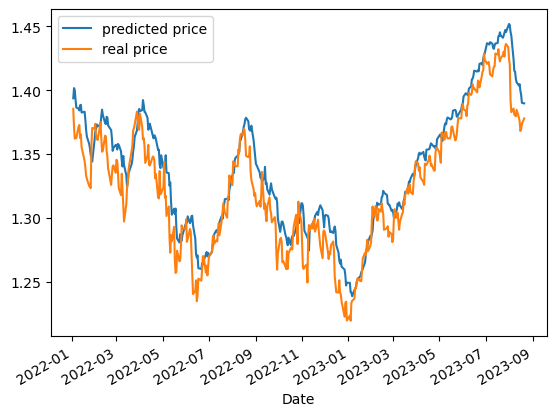

In [131]:
y_pred_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "predicted price"
    )

y_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "real price"
    )

# y_test[(y_pred_test.pct_change() < 0 ) & (y_test.index.get_level_values("ticker") == "AAPL")]\
#     .reset_index(level= "ticker")\
#     ["price"]\
#     .plot(
#         label = "buy",
#         marker = "^",
#         linestyle = "None",
#         color = "green"
#     )

# y_test[(y_pred_test.pct_change()>0 ) & (y_test.index.get_level_values("ticker") == "AAPL")]\
#     .reset_index(level= "ticker")\
#     ["price"]\
#     .plot(
#         label = "sell",
#         marker = "^",
#         linestyle = "None",
#         color = "red"
#     )

plt.legend()

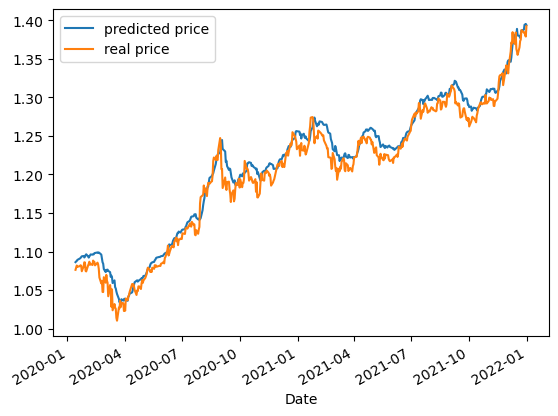

In [132]:
# plt.figure(figsize = (16,10))

y_pred_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "predicted price",
        # color = "blue"
    )

y_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "real price",
        # color = "blue"
    )




plt.legend()

## Creating signal

## PnL

In [133]:
y_pred_test.index.get_level_values("Date") > "2023"

array([False, False, False, ...,  True,  True,  True])

In [140]:
train = True
only_2023= False
num_trades = {}

pnls = {}

for ticker in tqdm(universe):
    company_train = y_pred_train\
        .index\
        .get_level_values("ticker") == ticker


    company_test = y_pred_test\
        .index\
        .get_level_values("ticker") == ticker
    
    if not train:
        y_company = y_test[company_test]
        y_pred_company = y_pred_test[company_test]

    else:
        y_company = y_train[company_train]\
            .sort_index(level = "Date")
        y_pred_company = y_pred_train[company_train]\
            .sort_index(level = "Date")
        

    if only_2023:
        idx = y_company\
            .index\
            .get_level_values("Date") > "2023"
        
        y_company = y_company[idx]
        y_pred_company = y_pred_company[idx]

    avg_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .mean()

    std_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .std()
    
    zscore = (y_pred_company.pct_change() - avg_price)/std_price

    positions = pd.Series(
        np.nan,
        index = y_pred_company.index,
        name = "position"
    )
    
    positions.loc[y_pred_company.pct_change() < 0]  = 1
    positions.loc[y_pred_company.pct_change() > 0] = -1 


    positions = positions\
        .fillna(0)
    
    num_long = (positions == 1).sum()/positions.shape[0]
    num_short = (positions == -1).sum()/positions.shape[0]

    num_trades[ticker] = {
        "num_long" : num_long,
        "num_short" : num_short
    }
    
    positions_df = pd.concat([y_company, positions], axis = 1)

    positions_df = positions_df\
        .reset_index(level = "ticker")

    pnl = pd.Series(
        0,
        index = positions_df.index,
        name = "pnl"
    )

    last_buy_price = np.nan
    cash = 0
    position = 0 

    returns = positions_df["price"]\
        .pct_change() * positions_df["position"].shift(1)
    # for date, row in positions_df.iterrows():
    #     first_trade = np.isnan(last_buy_price) and row["position"] != 0 
    #     has_position = not np.isnan(last_buy_price) and position != 0
    #     changing_position = has_position and row["position"] != position
    #     holding_position = has_position and row["position"] == position

    #     if (first_trade):
    #         last_buy_price = row["price"] 
    #         position = row["position"]

    #     if (changing_position):
    #         cash += (row["price"] / last_buy_price - 1 )*position
    #         # last_buy_price = np.nan
    #         position = row["position"]
            
    #         if (position == 0):
    #             last_buy_price = np.nan
    #         else:
    #             last_buy_price = row["price"] 

    #     if holding_position:
    #         pnl.loc[date] = (row["price"]- last_buy_price)/last_buy_price * position + cash

    #     else:
    #         pnl.loc[date] = cash

    # if row["position"] != 0:
    #     cash += (row["price"]- last_buy_price)/last_buy_price * position

    #     pnl.loc[date] = cash

    pnls[ticker] = returns
        

100%|██████████| 5/5 [00:00<00:00, 92.45it/s]


In [141]:
num_trades

{'AMZN': {'num_long': 0.4305835010060362, 'num_short': 0.5674044265593562},
 'AAPL': {'num_long': 0.36016096579476864, 'num_short': 0.6378269617706237},
 'MSFT': {'num_long': 0.4084507042253521, 'num_short': 0.5895372233400402},
 'FB': {'num_long': 0.4426559356136821, 'num_short': 0.5553319919517102},
 'GOOGL': {'num_long': 0.358148893360161, 'num_short': 0.6398390342052314}}

In [142]:
(positions == 1).sum()/positions.shape[0]

0.358148893360161

In [143]:
# torch.save(model.state_dict(), "data/models/GRU_sentiment_100_epoch.pt")

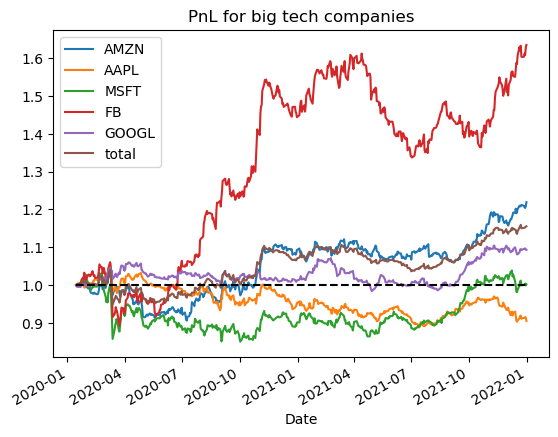

In [144]:
pnl_total = pd.Series(
    0,
    index = pnls["AAPL"].index
)
for k, pnl in pnls.items():
    # if k == "ADBE" or k == "ORCL":
    #     continue

    if k not in ["AAPL", "GOOGL", "FB", "AMZN", "MSFT"]:
        continue

    # if k != "NVDA":
        # continue

    pnl.add(1).cumprod().plot(
        label = k
    )


    pnl_total += pnl

(pnl_total/5).add(1).cumprod().plot(
    label = "total",
)

plt.hlines(
    y = 1,
    xmin= pnl_total.index[0],
    xmax = pnl_total.index[-1],
    colors= "black",
    linestyles= "dashed"
)

plt.title("PnL for big tech companies")
plt.legend()

In [158]:
s = "ola"
s[0:3]

'ola'

In [145]:
(pnl_total.mean())/pnl_total.std() * np.sqrt(252)

0.8953877559566968

## Correlation with tech index

In [72]:
prices_df = yf.download(
    tickers= "SPG",
    start="2019-12-30",
    end="2023-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [73]:
returns_etf = prices_df["Close"]\
    .pct_change()\
    .reindex(index= pnl.index)

In [92]:
returns_etf.mean()

0.0011487813754737985

In [93]:
pnl_total.diff().mean()

0.0009606879753582576

In [91]:
(pnl_total.diff() - returns_etf).mean() / pnl_total.diff().std() * np.sqrt(252)

-0.17594139456572447

In [264]:
prices_df["Close"].reindex(index = pnl_total.index).corr(pnl_total)

-0.5673033164614015

In [265]:
scaler = MinMaxScaler((0,1))
prices_close = scaler.fit_transform(prices_df[["Close"]])
# normalized_pnl = scaler.fit_transform(pd.DataFrame(pnl_total))

<Axes: xlabel='Date'>

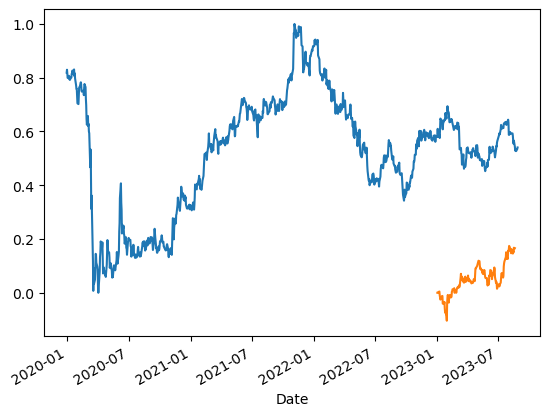

In [211]:
pd.Series(
    prices_close.reshape(-1),
    index = prices_df.index
).plot()
pnl_total.plot()